
(ﾉ ﾟｰﾟ)ﾉ
Tutorial (probably): https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

(ﾉ ﾟｰﾟ)ﾉ
Models:
https://pytorch.org/vision/stable/models.html#general-information-on-pre-trained-weights

(ﾉ ﾟｰﾟ)ﾉ
Datasets:
https://pytorch.org/vision/stable/datasets.html

In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import random

cudnn.benchmark = True
plt.ion()   # interactive mode

#don't forget: net.to(device)

## Hyperparams

In [3]:
batch_size=64
n_threads = 4

# hardware dependent:
data_folder = '.data'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Task1 - Dataset
Loading set + showing example images and size



### Load and visualize data

In [4]:
# new 
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

feature_transforms = transforms.Compose([
    transforms.ToTensor(),
])

# Create Omniglot dataset
trainset = torchvision.datasets.Omniglot(root=data_folder, background=True,
                                        download=True, transform=feature_transforms)

testset = torchvision.datasets.Omniglot(root=data_folder, background=False,
                                        download=True, transform=feature_transforms)

# Create data loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

trainsize = len(trainset)
testsize = len(testset)

#class_names = trainset.classes


Files already downloaded and verified
Files already downloaded and verified


In [5]:
next(iter(trainloader))[0].shape

torch.Size([64, 1, 105, 105])

Dataset length:  Dataset Omniglot
    Number of datapoints: 19280
    Root location: .data\omniglot-py
    StandardTransform
Transform: Compose(
               ToTensor()
           )


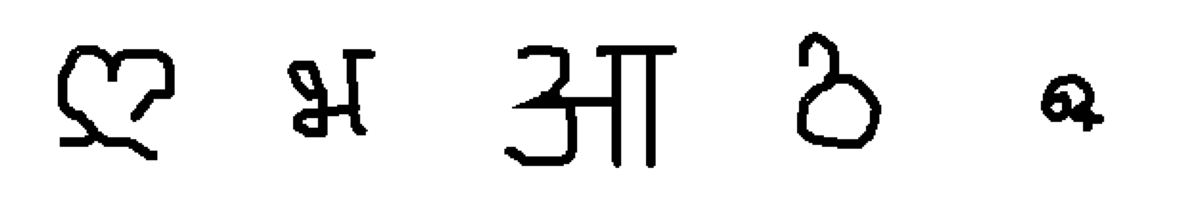

In [6]:
print('Dataset length: ', trainset)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images

random_indices = random.sample(range(len(trainset)), 5)
random_images = [trainset[i][0] for i in random_indices]

# Display random images
fig, axs = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    axs[i].imshow(random_images[i][0], cmap='gray')
    axs[i].axis('off')

plt.show()

### Finetuning
- every layer

In [7]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
num_characters = len(trainset._characters)
model_ft.fc = nn.Linear(num_ftrs, num_characters)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in trainloader:
                inputs = inputs.squeeze()
                inputs = torch.stack((inputs, inputs, inputs), dim=1)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(True):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            scheduler.step()

            epoch_loss = running_loss / len(trainset)
            epoch_acc = running_corrects.double() / len(trainset)

            print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            # if phase == 'val' and epoch_acc > best_acc:
            #     best_acc = epoch_acc
            #     torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [11]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
Train Loss: 6.4401 Acc: 0.0367

Epoch 1/24
----------
Train Loss: 4.8552 Acc: 0.2787

Epoch 2/24
----------
Train Loss: 3.5622 Acc: 0.5395

Epoch 3/24
----------
Train Loss: 2.5199 Acc: 0.7302

Epoch 4/24
----------
Train Loss: 1.7457 Acc: 0.8317

Epoch 5/24
----------
Train Loss: 1.2302 Acc: 0.8855

Epoch 6/24
----------
Train Loss: 0.9033 Acc: 0.9128

Epoch 7/24
----------
